# UMAP reduction of all COI

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# %load common_.py
from common import *

In [44]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load, correlation
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
import uuid

In [32]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    pandas.read_csv("data/selected_samples.csv"), "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [33]:
df = df[df["meta_label_coi"]]
df.shape

(293029, 113)

In [34]:
with open("data/selected_features.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [35]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [8]:
def zscore_feat_cols(col):
    if "feat" in col.name:
        return (col - col.mean(axis=0))/col.std(axis=0)
    else:
        return col

# df = df.apply(zscore_feat_cols, axis=0)

In [36]:
correlated_features = correlation.get_correlated_features(df.filter(regex="feat"), thresh=0.9055)

In [37]:
df = df.drop(columns=correlated_features)

In [38]:
df.shape

(293029, 82)

## Compute UMAP on all cells of interest

In [39]:
model = umap.UMAP(random_state=42, metric="euclidean")

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20).fit_transform(df.filter(regex="feat"))
pca.shape

(293029, 20)

In [81]:
%%time
projection = model.fit_transform(pca)

CPU times: user 15min 24s, sys: 4min 54s, total: 20min 18s
Wall time: 5min 5s


In [85]:
dump(projection, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/b16c9031-5995-4193-b0f7-23fddec6a215.dat']

In [12]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/2fb60822-4d6e-4067-914e-bc5311b3e713.dat")

In [82]:
df["dim_1"] = projection[:, 0]
df["dim_2"] = projection[:, 1]

In [83]:
pandas.options.plotting.backend = 'holoviews'

In [86]:
import hvplot.pandas
df.plot.scatter('dim_1', 'dim_2', datashade=True)

:DynamicMap   []
   :RGB   [dim_1,dim_2]   (R,G,B,A)

In [168]:
from matplotlib import cm

In [193]:
numpy.quantile(knn.data, 0.05)

48174.8251953125

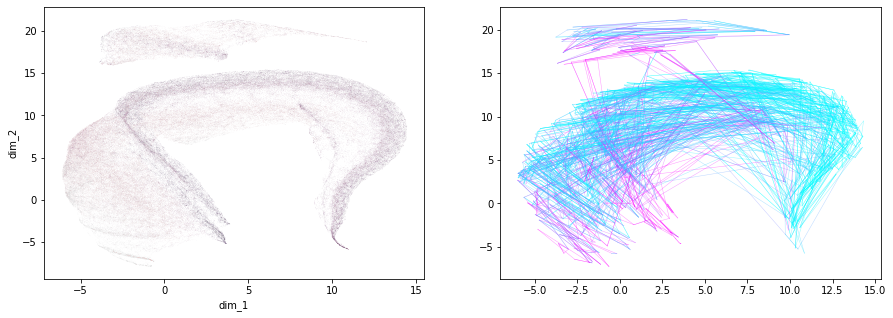

In [200]:
from sklearn.neighbors import kneighbors_graph
import scipy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_timepoint", s=0.02, legend=False, ax=ax1)

sample = df.sample(n=1000)
knn = kneighbors_graph(sample.filter(regex="feat"), n_neighbors=2, mode="distance", metric="cosine")
norm = matplotlib.colors.Normalize(vmin=numpy.quantile(knn.data, .1), vmax=numpy.quantile(knn.data, .9))
cmap = cm.get_cmap("cool")
for i in range(knn.shape[0]):
    for j in knn[i].nonzero()[1]:
        xx = [sample.iloc[i]["dim_1"], sample.iloc[j]["dim_1"]]
        yy = [sample.iloc[i]["dim_2"], sample.iloc[j]["dim_2"]]
        ax2.plot(xx, yy, alpha=0.4, c=cmap(norm(knn[i, j])), linewidth=.5)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

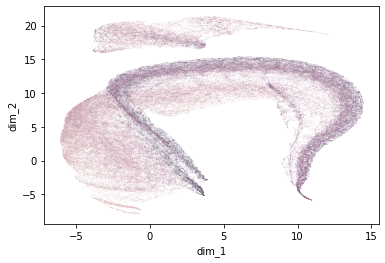

In [87]:
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_timepoint", s=0.05, legend=False)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

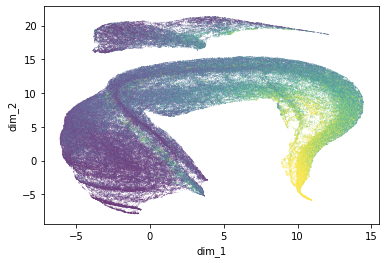

In [88]:
feat = "feat_area_m07"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

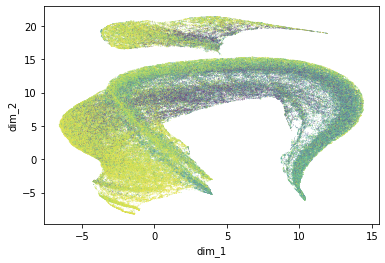

In [75]:
feat = "feat_aspect_ratio_intensity_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

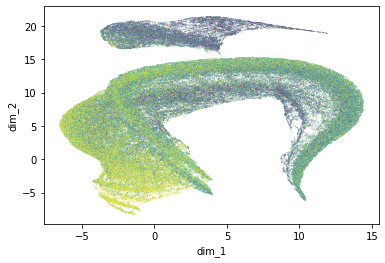

In [79]:
feat = "feat_aspect_ratio_m01"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

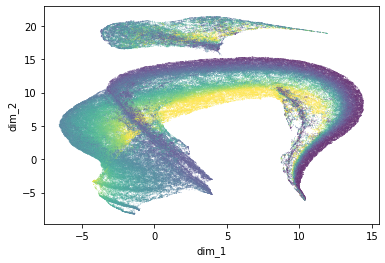

In [62]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

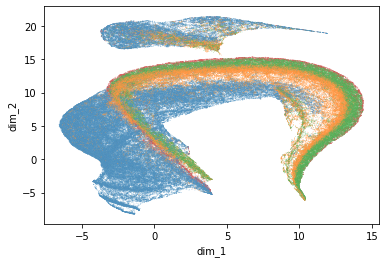

In [63]:
seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.5, alpha=0.5, legend=False, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])

In [70]:
corr = df.filter(regex="feat|dim").corr()

In [74]:
corr["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                                  1.000000
feat_max_pixel_mc_ssc                  0.491955
feat_intensity_mc_ssc                  0.432822
feat_aspect_ratio_intensity_m01_bf     0.391917
feat_aspect_ratio_intensity_m09_bf2    0.360132
feat_modulation_m09_bf2                0.350999
feat_aspect_ratio_m01                  0.346903
feat_contrast_m09_bf2                  0.332182
feat_aspect_ratio_m09                  0.328924
feat_modulation_m01_bf                 0.321775
feat_gradient_rms_m03_ch03             0.319914
feat_height_m09                        0.293799
feat_contrast_m01_bf                   0.293631
feat_intensity_mc_bf                   0.267071
feat_length_m01                        0.265505
feat_length_m09                        0.260698
feat_max_pixel_mc_bf2                  0.247707
feat_area_m06                          0.244858
feat_width_m06                         0.235814
feat_aspect_ratio_m03                  0.235588
Name: dim_2, dtype: float64

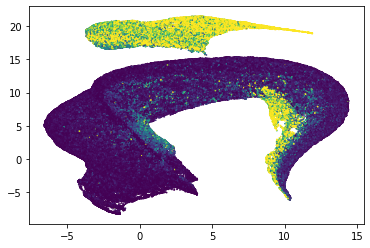

In [73]:
feat = "feat_max_pixel_mc_ssc"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.5, cmap="viridis", norm=norm)